# HH fitting to HH with wider ranges

In [1]:
from brian2 import *
from brian2tools import *


prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Input Data Preparation

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])*nA

input_current2 = np.stack((input_current0, input_current1))

In [4]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [5]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace0 = np.array([input_current0])
n0, n1 = inp_trace0.shape

out_trace0 = np.array(voltage[:n1])

In [7]:
start_scope()
I = TimedArray(input_current1, dt=dt)
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)

voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))
inp_trace1 = np.array([input_current1])
n0, n1 = inp_trace1.shape
out_trace1 = np.array(voltage[:n1])

In [8]:
# Generate Proper Input Format for the Problem
inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_trace = np.concatenate(([out_trace0], [out_trace1]))

## Model Fitting 

In [13]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm=1*ufarad*cm**-2 * area, El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)

In [13]:
start_scope()
n_opt = NevergradOptimizer()
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
                                   n_rounds=1, n_samples=5, optimizer=n_opt, metric=metric)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exponential_euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]


(10,)
round 0 with error 1.816620357525197


## Results Visualization

In [14]:
# get information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'g_na': 0.00016764316900926368, 'gl': 1.357037468831012e-07, 'g_kd': 7.425228424667396e-05}
error 1.816620357525197


In [18]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt)

fits/mV

array([[  0.        ,  -0.4395443 ,  -0.87600093, ..., -65.4894568 ,
        -65.48555139, -65.48167076],
       [  0.        ,  -0.4395443 ,  -0.87600093, ..., -64.70661404,
        -64.707645  , -64.70866937]])

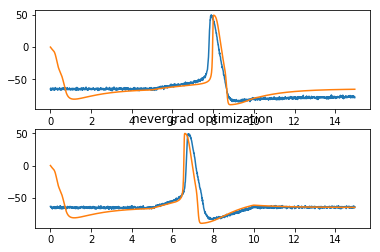

In [16]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(len(out_trace[0]))*dt/ms, out_trace[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);
ax[1].plot(np.arange(len(out_trace[1]))*dt/ms, out_trace[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);
plt.title('nevergrad optimization')
# plt.savefig('plots/hh_nevergrad.png')
plt.show()

In [40]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 20000*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 10000*msiemens*cm**-2 * area],
                                   n_rounds=10, n_samples=30, optimizer=n_opt, metric=metric)

(60,)
round 0 with error 2.214712292368492
(60,)
round 1 with error 1.8278576508431121
(60,)
round 2 with error 1.7493351401684625
(60,)
round 3 with error 1.6646363010419771
(60,)
round 4 with error 1.6547008884915062
(60,)
round 5 with error 2.0714657066307343
(60,)
round 6 with error 1.6595221855930258
(60,)
round 7 with error 1.6466862611783957
(60,)
round 8 with error 1.6466497774630047
(60,)
round 9 with error 1.6219640113912015


## Results Visualization

In [41]:
# get information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'g_na': 0.00017066988408372097, 'gl': 7.37343461847359e-08, 'g_kd': 0.0017266810053495826}
error 1.6219640113912015


In [42]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt)

fits/mV

array([[  0.        ,  -0.23919543,  -0.47779166, ..., -67.8517268 ,
        -67.8411529 , -67.8306174 ],
       [  0.        ,  -0.23919543,  -0.47779166, ..., -65.01114624,
        -65.01146337, -65.01177878]])

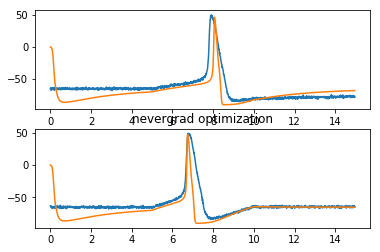

In [43]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(len(out_trace[0]))*dt/ms, out_trace[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);
ax[1].plot(np.arange(len(out_trace[1]))*dt/ms, out_trace[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);
plt.title('nevergrad optimization')
# plt.savefig('plots/hh_nevergrad.png')
plt.show()